Uso de Recomendação em Content Based para contratos de licitação

Aqui apresento implementações em [Python](https://www.python.org/) para recomendação de contrato para análise de legalidade de licitação baseada em conteúdo. Primeiramente, vamos carregar algumas bibliotecas necessárias para a implementação das abordagens:


In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to C:\Users\Leonardo
[nltk_data]     Vilela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga da Base de Dados
---
Esta carga será um evento simples pois os dados foram tratados em SGBD ORACLE previamente.

#### movies_metadata.csv

Contém informação sobre itens (filmes), tal como identificador, título, descrição textual, a língua.

In [2]:
#nltk.download('stopwords')

ratings = pd.read_excel(r'C:\Users\Leonardo Vilela\Documents\MESTRADO\RecSys\contratos\ranking.xlsx')
contratos = pd.read_excel(r'C:\Users\Leonardo Vilela\Documents\MESTRADO\RecSys\contratos\contratos_apenas.xlsx')


In [3]:
ratings.sort_values(by=['USER']).head(5)

,USER,RATING,CLASSE,COD
16079,1,0,6,18508
17327,1,0,2,25076
17326,1,0,2,25075
17325,1,0,2,25074
17324,1,0,2,25073


In [4]:
ratings.sort_values(by=['USER']).head(5)
contratos.sort_values(by=['COD']).head(5)


,COD,OBJETO
0,1,A Secretaria de Administração. Fazenda e Gover...
1,2,A Secretaria de Administração. Fazenda e Gover...
2,3,CONTRATACAO DE EMPRESA ESPECIALIZADA EM MANUTE...
3,4,CONTRATACAO DE EMPRESA ESPECIALIZADA EM MANUTE...
4,5,Recurso para credenciamento de pessoas jurídic...


#### Formação do arquivo de Treino


In [5]:
licitacoes_treino = pd.merge(ratings,contratos,on='COD')

## Abordagens de Recomendação
---
A seguir apresento quatro abordagens de recomendação: abordagem baseada em popularidade (PB), abordagem baseada em filtragem colaborativa (CF), abordagem baseada em conteúdo (CB) e abordagem híbrida (HB). Para a abordagem de filtragem colaborativa, foram implementadas quatro diferentes estratégias: baseada em usuário (CF-UB), baseada em item (CF-IB) e baseada em fatoração de matriz utilizando [decomposição de valores singulares](https://pt.wikipedia.org/wiki/Decomposi%C3%A7%C3%A3o_em_valores_singulares) (CF-SVD).

### Baseada em Conteúdo
Abordagens de recomendação baseadas em conteúdo levam em conta a descrição (ou atributos) de itens relevantes a usuários para sugerir itens similares. Elas consideram apenas escolhas prévias do próprio usuário, o que as torna resilientes ao problema de  [cold-start](https://en.wikipedia.org/wiki/Cold_start). Para recomendação de itens com farto conteúdo textual, como artigos, livros e notícias, o uso do texto associado ao item para construir perfis de itens e usuários se mostra uma tarefa muito simples e intuitiva.

Aqui utilizaremos um modelo clássico de recuperação de informação para representação de itens e usuários, o [modelo vetorial](https://pt.wikipedia.org/wiki/Modelo_vetorial_em_sistemas_de_recupera%C3%A7%C3%A3o_da_informa%C3%A7%C3%A3o). Nesse modelo, textos não estruturados são convertidos em vetores de palavras, onde cada palavra é representada por uma posição no vetor e o valor nessa posição indica a importância (peso) da palavra no texto. Como todos os itens e usuários são representados em um espaço vetorial, o cálculo de similaridade entre itens e usuários pode ser feito utilizando o cosseno ([cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity)) entre seus respectivos vetores. Para o cálculo do peso das palavras no texto geralmente utiliza-se o [esquema TF-IDF](https://pt.wikipedia.org/wiki/Tf%E2%80%93idf), onde a frequência da palavra no texto e a raridade da palavra entre os diversos textos determinam sua importância.

In [6]:
stopwords_list = stopwords.words('portuguese')
licitacoes_treinoIDX=licitacoes_treino.set_index('USER')
#CRIANDO UM VETOR DE PALAVRAS TFIDF
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.8,
                     max_features=5000,
                     stop_words=stopwords_list)
#POPULANDO OBJETOS 
item_ids = licitacoes_treino['COD'].tolist()

#TRANSFORMANDO O VETOR EM MATRIZ
tfidf_matrix = vectorizer.fit_transform(licitacoes_treino['OBJETO']) 
#LISTANDO TODAS AS PALAVRAS ENCONTRADAS
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

C:\Users\Leonardo Vilela\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


<32160x1484 sparse matrix of type '<class 'numpy.float64'>'
	with 771944 stored elements in Compressed Sparse Row format>

Para modelar o perfil de usuário, utilizaremos todos os perfis de itens que o usuário atribuiu *rating*. Mais especificamente, o vetor de palavras representativos de um usuário será constituído por todas as palavras presentes nos vetores de itens que o usuário atribuiu *rating* e os pesos de cada palavra serão determinados pelo TF-IDF ponderado pelo *rating* do usuário.

In [7]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles


def build_users_profile(userId, ratings_indexed_df):
    ratings_person_df = ratings_indexed_df.loc[userId]
    user_item_profiles = get_item_profiles(ratings_person_df['COD'])
    
    user_item_strengths = np.array(ratings_person_df['RATING']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    #user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_item_strengths_weighted_avg

def build_users_profiles():        
    user_profiles = {}
    for userId in licitacoes_treinoIDX.index.unique():
        user_profiles[userId] = build_users_profile(userId, licitacoes_treinoIDX)
    return user_profiles

In [8]:
userProfiles = build_users_profiles()
len(userProfiles)

7

Para simplificar e tornar os cálculos mais rápidos, faremos uma poda nos vetores de palavras e fixaremos o tamanho máximo do vetor em 5.000 palavras. Observando o perfil de um usuário específico, espera-se que as palavras mais representativas no perfil do usuário estejam realmente relacionadas aos conceitos que o usuário se interessa. 

In [9]:
user1 = userProfiles[1]
print(user1.shape)



(1, 1484)


Agora, vamos implementar a abordagem de recomendação baseada em conteúdo:

In [10]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(userProfiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #envolved=licitacoes_treino.loc[licitacoes_treino['USER'] == user_id ]
        #items_to_ignore = envolved['COD'].tolist()
        #Ignores items the user has already interacted
        #licitacoes_inter = licitacoes_treino.loc[user_id]
        #items_to_ignore= licitacoes_inter['COD']
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['COD', 'RATING']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'COD', 
                                                          #right_on = 'COD')[['PARECER', 'COD', 'OBJETO']]
                                                          right_on = 'COD')[['COD', 'OBJETO']]  

        return recommendations_df

In [11]:
CBModel = ContentBasedRecommender(licitacoes_treinoIDX)

contentBased= CBModel.recommend_items(4, topn=10, verbose=True)



Finalmente, vamos conferir as recomendações oferecidas pela abordagem para um usuário específico de nossa base de dados:

In [12]:
print (contentBased)

    COD                          OBJETO
0   233             AQUISIÇÃO DE LIVROS
1  6523             AQUISIÇÃO DE LIVROS
2   236             AQUISIÇÃO DE LIVROS
3  6522             AQUISIÇÃO DE LIVROS
4   240             AQUISIÇÃO DE LIVROS
5  3000  AQUISIÇÃO DE LIVROS LITERARIOS
6  6524             AQUISIÇÃO DE LIVROS
7   206             AQUISIÇÃO DE LIVROS
8  6314                LIVROS DIDATICOS
9  6315                LIVROS DIDATICOS


In [13]:
def MAE(y_true, y_score):
    return (np.absolute(y_true - y_score)).sum() / len(y_true)

In [14]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 7, 5, 8, 3])
print("MAE: %f" % MAE(oracle,score))

MAE: 0.800000


In [15]:
def MSE(y_true, y_score):
    return np.power((y_true - y_score),2).sum() / len(y_true)

In [16]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 7, 5, 8, 3])
print("MSE: %f" % MSE(oracle,score))

MSE: 0.800000


In [17]:
def RMSE(y_true, y_score):
    return sqrt(np.power((y_true - y_score),2).sum() / len(y_true))

In [18]:


score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 7, 5, 8, 3])
print("RMSE: %f" % RMSE(oracle,score))

RMSE: 0.894427


In [19]:
def Precision(y_true, y_score, k=None):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]

    if k is not None:
        rating = rating[0:k]
        
    return np.count_nonzero(rating) / len(rating)

In [20]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("Precision: %f" % Precision(oracle,score))

Precision: 0.800000


In [21]:
def Recall(y_true, y_score, k=None):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]
    allRelevant = np.count_nonzero(rating)

    if k is not None:
        rating = rating[0:k]
        
    return np.count_nonzero(rating) / allRelevant

In [22]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("Recall: %f" % Recall(oracle,score,k=3))

Recall: 0.500000


In [23]:
def getPrecision(hits):
    v=np.cumsum(hits)[::-1]
    v=np.where((v[1:] - v[:-1]) == 0, 0, v[:-1])
    v=np.append(v, hits[0])
    pos=np.arange(len(hits))+1
    return v[::-1] / pos

def AveragePrecision(y_true, y_score, k=None, binary=True):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]
    if k is not None:
        rating = rating[0:k]
    hits=np.where(rating > 0, 1, 0)
    if binary:
        rating=hits
    precision = getPrecision(hits)
    return (rating * precision).sum() / np.count_nonzero(hits)

In [24]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("AP: %f" % AveragePrecision(oracle,score,k=3))

AP: 0.833333


In [25]:
def getCumulativeGain(y_true, y_score, k=None):
    ranking = np.argsort(y_score)[::-1]
    rating = y_true[ranking]
    if k is not None:
        rating = rating[0:k]    
    logIndices = np.log2(np.arange(len(rating))+2)
    return (rating / logIndices).sum()


def nDCG(y_true, y_score, k=None):
    gain = getCumulativeGain(y_true, y_score, k)
    norm = getCumulativeGain(y_true[np.argsort(y_true)[::-1]], y_score[np.argsort(y_score)[::-1]], k)
    return gain / norm

In [26]:
score=np.array([1, 8, 6, 9, 4])
oracle=np.array([1, 0, 1, 4, 1])
print("DCG: %f" % getCumulativeGain(oracle,score,k=3))
print("nDCG: %f" % nDCG(oracle,score,k=3))

DCG: 4.500000
nDCG: 0.877034


### Modelos de Avaliação

---

Como existem diferenças na forma como as abordagens de recomendação são capazes de entregar os resultados, se faz necessário desenvolver diferentes modelos para avaliação das abordagens. Por exemplo, para abordagens capazes de entregar listas ordenadas (ranking) de recomendações é adequado utilizar modelos que avaliem a qualidade do ranking entregue. Já para abordagens capazes de entregar *ratings* de usuários em itens é adequado utilizar modelos que avaliem o quanto os *ratings* entregues são próximas dos *ratings* reais, aquelas o usuário efetivamente atribuiria a itens.

#### Ranking

---

O modelo de avaliação de ranking aqui utilizado considera que cada abordagem avaliada seja capaz de sugerir aos usuários um ranking de $k$ itens relevantes. Particularmente, cada abordagem é capaz de associar a cada um dos $k$ items que o usuário não atribuiu *rating* uma medida (*score*) que permite a ordenação dos itens em uma lista de recomendação onde os top-$n$ elementos serão utilizados no cálculo da acurácia da abordagem.

In [27]:
class RankingEvaluator:
     
    def getRatedItems(self, user_id, ratingsDF):
        ratedItems = ratingsDF.loc[user_id]['COD']
        return set(ratedItems if type(ratedItems) == pd.Series else [ratedItems])

    def evaluateModelForUser(self, model, user_id, k=1000, n=10):
        relevantItems = ratingsTestIndexedDF.loc[user_id]
        if type(relevantItems['COD']) == pd.Series:
            relevantItems = set(relevantItems['COD'])
        else:
            relevantItems = set([int(relevantItems['COD'])])
        if (not relevantItems or len(relevantItems) < n):
            return {}
          
        APValue = 0
        nDCG1Value = 0
        nDCG3Value = 0
        nDCG5Value = 0
        nDCG10Value = 0
        recommendationsDF = model.recommend_items(user_id, 
                                            items_to_ignore=self.getRatedItems(user_id, ratingsTrainIndexedDF), 
                                            topn=k)[['COD', 'RATING']]
        oracleDF = recommendationsDF['COD'].isin(relevantItems)
        if (any(oracleDF)):
            APValue = AveragePrecision(oracleDF.values.flatten(), recommendationsDF['RATING'].values.flatten())
            nDCG1Value = nDCG(oracleDF.values.flatten(), recommendationsDF['RATING'].values.flatten(), k=1)            
            nDCG3Value = nDCG(oracleDF.values.flatten(), recommendationsDF['RATING'].values.flatten(), k=3)
            nDCG5Value = nDCG(oracleDF.values.flatten(), recommendationsDF['RATING'].values.flatten(), k=5)
            nDCG10Value = nDCG(oracleDF.values.flatten(), recommendationsDF['RATING'].values.flatten(), k=10)
            
        userMetrics = {'relevant': len(relevantItems), 
                      'AP': APValue,
                      'nDCG@1': nDCG1Value,
                      'nDCG@3': nDCG3Value,
                      'nDCG@5': nDCG5Value,
                      'nDCG@10': nDCG10Value}
        return userMetrics

    def evaluate(self, model, k=1000, n=10):
        usersMetrics = []
        for idx, user_id in enumerate(list(ratingsTestIndexedDF.index.unique().values)):
            userMetrics = self.evaluateModelForUser(model, user_id, k, n) 
            if (not userMetrics):
              continue;
            userMetrics['USER'] = user_id
            usersMetrics.append(userMetrics)

        resultsDF = pd.DataFrame(usersMetrics) \
                      .sort_values('relevant', ascending=False)
        
        globalMAP = resultsDF['AP'].sum() / float(len(resultsDF))
        globalNDCG1 = resultsDF['nDCG@1'].sum() / float(len(resultsDF))
        globalNDCG3 = resultsDF['nDCG@3'].sum() / float(len(resultsDF))       
        globalNDCG5 = resultsDF['nDCG@5'].sum() / float(len(resultsDF))
        globalNDCG10 = resultsDF['nDCG@10'].sum() / float(len(resultsDF))

        globalMetrics = {'modelName': model.get_model_name(),
                          'MAP': globalMAP,
                          'nDCG@1': globalNDCG1,
                          'nDCG@3': globalNDCG3,
                          'nDCG@5': globalNDCG5,
                          'nDCG@10': globalNDCG10}  
        
        return globalMetrics, resultsDF
    
rankingEvaluator = RankingEvaluator()

Cabe ressaltar que as métricas de avaliação de acurácia utilizadas por esse modelo devem ser métricas de relevância que captem a qualidade do ranking entregue pela abordagem, tais como $P$, $R$, $AP$ e $nDCG$. 

## Experimentos e Resultados

---

Nossa avaliação se concentrará no aspecto da acurácia e usaremos o método de validação cruzada com  [holdout](https://pt.wikipedia.org/wiki/Valida%C3%A7%C3%A3o_cruzada#M%C3%A9todo_holdout) com uma amostra aleatória de 80% dos dados para treino das abordagens de recomendação e os 20% restantes para teste.
Para todas as abordagens avaliadas utilizaremos o modelo de avaliação de ranking reportando as métricas $MAP$ (acrônimo em inglês para *Mean Average Precision*), $nDCG@1$, $nDCG@3$, $nDCG@5$ e $nDCG@10$ e para as abordagens de filtragem colaborativa utilizaremos também o modelo de avaliação de *rating* reportando as métricas $MAE$, $MSE$ e $RMSE$, uma vez que se trata de abordagens capazes de entregar, além de listas de recomendações, *ratings* de usuários em itens.

In [28]:
from sklearn.model_selection import train_test_split
ratingsDF = licitacoes_treino
ratingsTrainDF, ratingsTestDF = train_test_split(ratingsDF,
                                                 stratify=ratingsDF['USER'], 
                                                 test_size=0.20,
                                                 random_state=73)

print('# de ratings no subconjunto de treino: %d' % len(ratingsTrainDF))
print('# de ratings no subconjunto de teste: %d' % len(ratingsTestDF))

# de ratings no subconjunto de treino: 25728
# de ratings no subconjunto de teste: 6432


In [29]:
#Indexing by userId to speed up the searches during evaluation
ratingsIndexedDF = ratingsDF.set_index('USER')
ratingsTrainIndexedDF = ratingsTrainDF.set_index('USER')
ratingsTestIndexedDF = ratingsTestDF.set_index('USER')
CBModel = ContentBasedRecommender(ratingsTrainIndexedDF)

contentBased= CBModel.recommend_items(4, topn=10, verbose=True)

### Baseada em Conteúdo

---



In [30]:
print('Avaliando a abordagem %s...' % CBModel.get_model_name())
CBGlobalMetricsRankingDF, CBDetailedMetricsRankingDF = rankingEvaluator.evaluate(CBModel)
print('\nMétricas Globais:\n%s' % CBGlobalMetricsRankingDF)

Avaliando a abordagem Content-Based...

Métricas Globais:
{'modelName': 'Content-Based', 'MAP': 0.6902166893237223, 'nDCG@1': 0.8571428571428571, 'nDCG@3': 0.8236229481412316, 'nDCG@5': 0.8423665306429948, 'nDCG@10': 0.8469860033727026}


In [31]:
CBDetailedMetricsRankingDF = CBDetailedMetricsRankingDF[['USER', 'relevant', 'AP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
CBDetailedMetricsRankingDF.sort_values(by=['USER']).head(5)

,USER,relevant,AP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
2,1,2101,0.781615,1.0,1.0,1.0,1.0
3,2,913,0.824108,1.0,1.0,1.0,1.0
6,3,347,0.991972,1.0,1.0,1.0,1.0
1,4,1140,0.743324,1.0,1.0,1.0,1.0
0,5,1770,0.851272,1.0,1.0,1.0,1.0


### Análise Comparativa
---


In [32]:
globalRankingMetricsDF = pd.DataFrame([CBGlobalMetricsRankingDF])
globalRankingMetricsDF = globalRankingMetricsDF[['modelName', 'MAP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']]
globalRankingMetricsDF.columns = ['Abordagem', 'MAP', 'nDCG@1', 'nDCG@3', 'nDCG@5', 'nDCG@10']
globalRankingMetricsDF = globalRankingMetricsDF.set_index('Abordagem')
globalRankingMetricsDF

,MAP,nDCG@1,nDCG@3,nDCG@5,nDCG@10
Abordagem,,,,,
Content-Based,0.690217,0.857143,0.823623,0.842367,0.846986


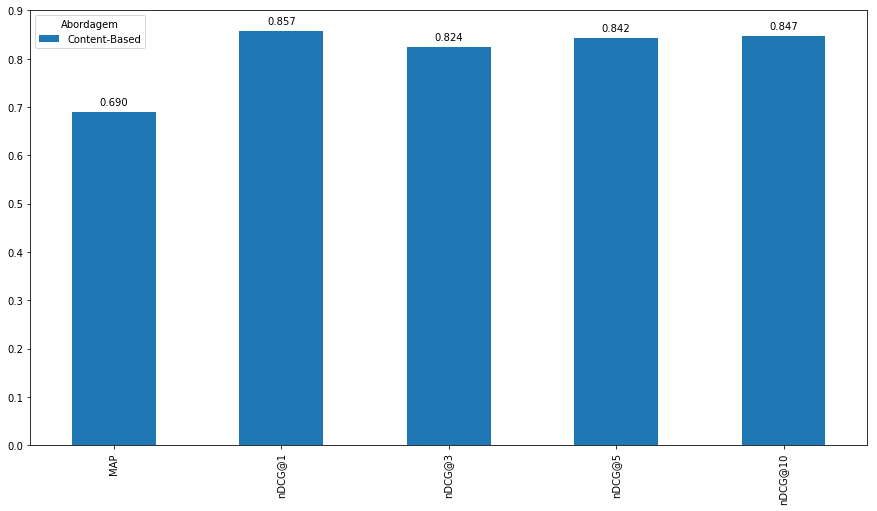

In [33]:
%matplotlib inline
ax = globalRankingMetricsDF.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')